In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import numpy as np 
import os.path as op
import itertools

from necessity_functions import NecessityUnivariate, NecessityBivariate
from robust_set_sampling import RobustCredalSetUnivariate, RobustCredalSetBivariate
from copulas import min_copula, lukaciewicz_copula, frank_copula, ali_mikhail_haq_copula, clayton_copula, gumbel_copula

### Test orders on a given couple of possibilities

In [ ]:
x_space = ["x1", "x2", "x3"]
y_space = ["y1", "y2", "y3"]

poss_x = {'x1':0.2, "x2":1, "x3":0.7}
poss_y = {'y1':0.2, "y2":1, 'y3': 0.7}

order_x_precise = pd.DataFrame(columns=["order"], index=x_space, data=range(1, len(x_space) + 1))
order_y_precise = pd.DataFrame(columns=["order"], index=y_space, data=range(1, len(y_space) + 1))

In [ ]:
theta = 2
def copula(u, v):
    return clayton_copula(u, v, theta)

In [ ]:
 # Initializing the dataframe that stores results
multi_col = pd.MultiIndex.from_tuples(list(
    zip(["poss"] * (len(x_space) + len(y_space)) + ["focal_sets", "focal_sets"],
        x_space + y_space + ["X", "Y"])), names=["Object", "Space"])
multi_index = pd.MultiIndex.from_product([pd.Index(name = "poss", data=[]), pd.Index(name="order", data=[])])

final_df = pd.DataFrame(columns=multi_col, index=multi_index)

In [ ]:
# Finding focal sets
nec_x_vanilla = NecessityUnivariate(poss_x)
rob_x = RobustCredalSetUnivariate(nec_x_vanilla, samples_per_interval=10)

nec_y_vanilla = NecessityUnivariate(poss_y)
rob_y = RobustCredalSetUnivariate(nec_y_vanilla, samples_per_interval=10)

rob_xy = RobustCredalSetBivariate(rob_x, rob_y, order_x_precise, order_y_precise, copula)

In [ ]:
rob_xy.approximation

In [ ]:
rob_xy.approximation.to_csv("/work/scratch/malinoro/simulation_copula/robust_xy_clayton_2.csv")

In [ ]:
# Testing orders
flag_order_work = False

# Creating a complex dataframe: rows being events and columns being different orders on focal sets
i1 = []
for perm_x in itertools.permutations(range(1, len(nec_x_vanilla.mass.index) + 1)):
    order_x = pd.DataFrame(columns=["order"], index=nec_x_vanilla.mass.index, data=perm_x)
    i1 += ["<".join(order_x.sort_values(by="order").index)]
    
i2 = []
for perm_y in itertools.permutations(range(1, len(nec_y_vanilla.mass.index) + 1)):
    order_y = pd.DataFrame(columns=["order"], index=nec_y_vanilla.mass.index, data=perm_y)
    ["<".join(order_y.sort_values(by="order").index)]
    
col_multi = pd.MultiIndex.from_product([i1, i2], names=["order_X", "order_Y"])

nec_xy_inf = pd.DataFrame(index=rob_xy.approximation.index, columns=col_multi)
nec_xy_inf.fillna(value=2, inplace=True)

print("Starting permutations") 
for perm_x in itertools.permutations(range(1, len(nec_x_vanilla.mass.index) + 1)):
    order_x = pd.DataFrame(columns=["order"], index=nec_x_vanilla.mass.index, data=perm_x)
    nec_x = NecessityUnivariate(poss_x, order_x)

    for perm_y in itertools.permutations(range(1, len(nec_y_vanilla.mass.index) + 1)):
        order_y = pd.DataFrame(columns=["order"], index=nec_y_vanilla.mass.index, data=perm_y)
        nec_y = NecessityUnivariate(poss_y, order_y)

        nec_xy = NecessityBivariate(nec_x, nec_y, copula)
        
        key_x = "<".join(order_x.sort_values(by="order").index)
        key_y = "<".join(order_y.sort_values(by="order").index)
        nec_xy_inf.loc[:, (key_x, key_y)] = np.array(nec_xy.necessity.loc[nec_xy.necessity.index, "Nec"])

        if ((rob_xy.approximation["P_inf"] - nec_xy.necessity["Nec"]) > - rob_xy.rob_x.epsilon).all():
            flag_order_work = True

if not flag_order_work:
    print("No order is working!")

In [ ]:
nec_xy_inf.to_csv("nec_inf_clayton_2.csv")

In [ ]:
# Or if we want to resume some computation
nec_xy_inf = pd.read_csv("/work/scratch/malinoro/simulation_copula/nec_inf_clayton_2.csv", index_col=[0, 1], header=[0, 1])
rob_xy.approximation = pd.read_csv("/work/scratch/malinoro/simulation_copula/robust_xy_clayton_2.csv", index_col=[0, 1])

## Finding two couples of events such that Nec cannot be inferior to P_inf on those two events at the same time

In [ ]:
list_event = []

for xy1 in nec_xy_inf.index:
    rob_1 = rob_xy.approximation.loc[xy1, "P_inf"]
    
    for xy2 in nec_xy_inf.index:
        rob_2 = rob_xy.approximation.loc[xy2, "P_inf"]

                
        arr_bool_1 = nec_xy_inf.loc[xy1, :] > (rob_1 + rob_xy.rob_x.epsilon)
        arr_bool_2 = nec_xy_inf.loc[xy2, :] > (rob_2 + rob_xy.rob_y.epsilon)

        if (arr_bool_1 | arr_bool_2).all():
            list_event += [(xy1, xy2)]

list_event = list(set(list_event))

print(list_event)

In [ ]:
print(rob_xy.approximation.loc[[('x2', 'y2,y3'), ('x2,x3', 'y2')], "P_inf"])
nec_1 = pd.DataFrame(index=nec_xy_inf.columns.get_level_values(level="order_X").drop_duplicates(), columns=nec_xy_inf.columns.get_level_values(level="order_Y").drop_duplicates())
nec_2 = pd.DataFrame(index=nec_xy_inf.columns.get_level_values(level="order_X").drop_duplicates(), columns=nec_xy_inf.columns.get_level_values(level="order_Y").drop_duplicates())

for x_i, y_i in nec_xy_inf.columns:
    nec_1.loc[x_i, y_i] = nec_xy_inf.loc[('x2', 'y2,y3'), (x_i, y_i)]
    nec_2.loc[x_i, y_i] = nec_xy_inf.loc[('x2,x3', 'y2'), (x_i, y_i)]
nec_1 = nec_1.astype(float).round(3)
nec_2 = nec_2.astype(float).round(3)

nec_1

In [ ]:
nec_2

# Copula Visualisation

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [ ]:
# Make data.
X = np.arange(0, 1, 0.05)
Y = np.arange(0, 1, 0.05)
X, Y = np.meshgrid(X, Y)

theta = 5

Z = np.zeros(X.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = frank_copula(X[i,j], Y[i,j], theta)

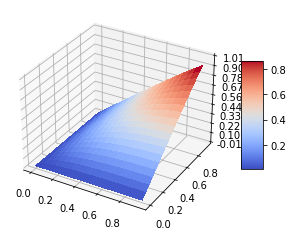

In [11]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

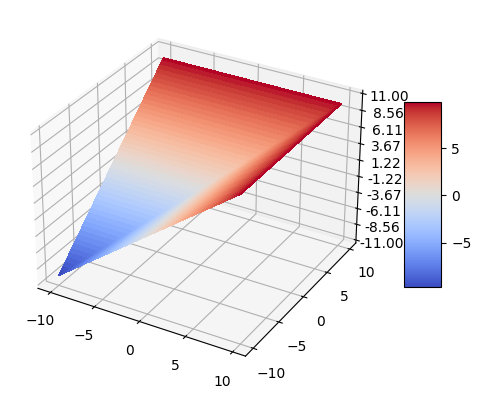

In [8]:
# Make data.
X = np.arange(-10, 10, 0.1)
Y = np.arange(-10, 10, 0.1)
X, Y = np.meshgrid(X, Y)


Z = np.maximum(X,Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-11, 11)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [7]:
np.maximum(np.arange(9).reshape((3,3)), np.linspace(-2,11,9).reshape((3,3)))

array([[ 0.   ,  1.   ,  2.   ],
       [ 3.   ,  4.5  ,  6.125],
       [ 7.75 ,  9.375, 11.   ]])

In [1]:
1920/1080

1.7777777777777777

In [2]:
16/9

1.7777777777777777